# Курсовой проект

## Описание проекта
**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

## Загрузка необходимых библиотек

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set()
sns.set_palette('husl')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'


from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC

import xgboost as xgb, lightgbm as lgbm, catboost as catb
from catboost import Pool, cv

import warnings
warnings.simplefilter('ignore')

In [2]:
def fill_col(col):
    '''Fill the gaps by the median value.'''
    train[col].fillna(train[col].median(), inplace=True)

In [3]:
def fill_col_test(col):
    '''Fill the gaps by the median value from Train.'''
    test[col].fillna(train[col].median(), inplace=True)

## Обзор данных<a class="anchor" id="course_project_review"></a>
**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

#### Пути к директориям и файлам

In [4]:
# input
# TRAIN_DATASET_PATH = './course_project_train.csv'
# TEST_DATASET_PATH = './course_project_test.csv'
TRAIN_DATASET_PATH = './kaggle/train.csv'
TEST_DATASET_PATH = './kaggle/test.csv'

#### Загрузка данных

In [5]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            7500 non-null   int64  
 1   Home Ownership                7500 non-null   object 
 2   Annual Income                 5943 non-null   float64
 3   Years in current job          7129 non-null   object 
 4   Tax Liens                     7500 non-null   float64
 5   Number of Open Accounts       7500 non-null   float64
 6   Years of Credit History       7500 non-null   float64
 7   Maximum Open Credit           7500 non-null   float64
 8   Number of Credit Problems     7500 non-null   float64
 9   Months since last delinquent  3419 non-null   float64
 10  Bankruptcies                  7486 non-null   float64
 11  Purpose                       7500 non-null   object 
 12  Term                          7500 non-null   object 
 13  Cur

In [7]:
train.describe()

,Id,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7500.000000,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,3749.500000,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,2165.207842,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,0.000000,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,1874.750000,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,3749.500000,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,5624.250000,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,7499.000000,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            2500 non-null   int64  
 1   Home Ownership                2500 non-null   object 
 2   Annual Income                 1987 non-null   float64
 3   Years in current job          2414 non-null   object 
 4   Tax Liens                     2500 non-null   float64
 5   Number of Open Accounts       2500 non-null   float64
 6   Years of Credit History       2500 non-null   float64
 7   Maximum Open Credit           2500 non-null   float64
 8   Number of Credit Problems     2500 non-null   float64
 9   Months since last delinquent  1142 non-null   float64
 10  Bankruptcies                  2497 non-null   float64
 11  Purpose                       2500 non-null   object 
 12  Term                          2500 non-null   object 
 13  Cur

In [9]:
test.describe()

,Id,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,2500.00000,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,8749.50000,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,721.83216,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,7500.00000,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8124.75000,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,8749.50000,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,9374.25000,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,9999.00000,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


### Анализ признаков с пропусками

In [10]:
len(train) - train.count()

Id                                 0
Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [11]:
len(test) - test.count()

Id                                 0
Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

#### Пропуски в числовых признаках

In [12]:
def feature_corr_plot(df, feature):
    plt.figure(figsize=(8, 6))
    sns.barplot(x=df.corr().loc[feature].sort_values(ascending=False).values, 
                y=df.corr().loc[feature].sort_values(ascending=False).index)
    plt.title(f'Correlation with {feature}')

Заполним пропуски признака "Months since last delinquent" нулями

In [13]:
train['Months since last delinquent'].fillna(0, inplace=True)
test['Months since last delinquent'].fillna(0, inplace=True)

Признаки "Annual Income" иимеют много пропусков. Заполним пропуски

In [14]:
train.loc[train['Annual Income'].isnull(), :].describe()

,Id,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,1557.000000,0.0,1557.000000,1557.000000,1557.000000,1.557000e+03,1557.000000,1557.000000,1555.000000,1557.000000,1.557000e+03,1557.000000,0.0,1557.000000
mean,3690.201028,NaN,0.033398,11.151574,18.336737,1.489092e+06,0.171484,15.170841,0.113826,300744.253051,2.860604e+05,18451.107900,NaN,0.339756
std,2177.866805,NaN,0.280313,4.935590,7.038592,3.305621e+07,0.500137,22.400430,0.327673,179179.260062,3.048984e+05,12084.036473,NaN,0.473778
min,5.000000,NaN,0.000000,2.000000,4.300000,0.000000e+00,0.000000,0.000000,0.000000,21472.000000,0.000000e+00,0.000000,NaN,0.000000
25%,1742.000000,NaN,0.000000,8.000000,13.500000,2.832280e+05,0.000000,0.000000,0.000000,167684.000000,1.140760e+05,10071.000000,NaN,0.000000
50%,3747.000000,NaN,0.000000,10.000000,17.300000,4.862660e+05,0.000000,0.000000,0.000000,262856.000000,2.058650e+05,16048.000000,NaN,0.000000
75%,5583.000000,NaN,0.000000,14.000000,21.900000,7.942660e+05,0.000000,28.000000,0.000000,404096.000000,3.572190e+05,23883.000000,NaN,1.000000
max,7499.000000,NaN,4.000000,33.000000,51.900000,1.304726e+09,5.000000,83.000000,2.000000,788942.000000,3.944514e+06,96177.000000,NaN,1.000000


In [15]:
# feature_corr_plot(train, 'Annual Income')

Самая высокая корреляция с признаками 'Monthly Debt' и 'Current Credit Balance'. Попробуем рассчитать недостающие значение 'Annual Income' следующим образом:
 - вычислим коэффициент, как отношение среднего 'Annual Income' к 'Monthly Debt'
 - вычислим 'Annual Income' как произведение коэффициента на значение 'Monthly Debt'

In [16]:
notnull_annual_income = train.loc[train['Annual Income'].notnull(), :]
coeff_1 = notnull_annual_income['Annual Income'].mean() / notnull_annual_income['Monthly Debt'].mean()
train['Annual Income'].fillna(train['Monthly Debt'] * coeff_1, inplace=True)
test['Annual Income'].fillna(test['Monthly Debt'] * coeff_1, inplace=True)

In [17]:
train['Credit Score']

0        749.0
1        737.0
2        742.0
3        694.0
4        719.0
         ...  
7495     697.0
7496    7410.0
7497     748.0
7498       NaN
7499       NaN
Name: Credit Score, Length: 7500, dtype: float64

In [18]:
# feature_corr_plot(train, 'Credit Score')

Самая высокая корреляция с целевым признаком 'Credit Default'.

In [19]:
train['Credit Score'].fillna(3000, inplace=True)
test['Credit Score'].fillna(3000, inplace=True)

In [20]:
fill_col('Bankruptcies')
fill_col_test('Bankruptcies')

#### Пропуски в нечисловых признаках

In [21]:
def fill_nom_col(col):   
    '''Fill the gaps with the mode'''
    train[col].fillna(train[col].mode().iloc[0], inplace=True)

In [22]:
def fill_nom_col_test(col):  
    '''Fill the gaps with the mode estimated on Train'''
    test[col].fillna(train[col].mode().iloc[0], inplace=True)

In [23]:
fill_nom_col('Years in current job')
fill_nom_col_test('Years in current job')

### Обзор данных

In [24]:
def correl_matrix(df):
    plt.figure(figsize = (10, 10))

    sns.set(font_scale=0.8)
    sns.heatmap(df[:].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

    plt.title('Матрица корреляции всех признаков')
    plt.show()

In [25]:
# correl_matrix(train)

### Обзор целевого признака

In [26]:
train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [27]:
target = 'Credit Default'

In [28]:
# plt.figure(figsize=(6, 4))
# sns.countplot(x=target, data=train)
# plt.title('Распределение целевого признака');

Данные несбалансированы

### Обработка числовых признаков

In [29]:
# feature_corr_plot(train, target)

In [30]:
def feat_plot(col):        
    fig, ax = plt.subplots(nrows=1, ncols=4)
    ax1, ax2, ax3, ax4 = ax.flatten()
    
    default = train.loc[train ['Credit Default'] == 1, col]
    not_default = train.loc[train ['Credit Default'] == 0, col]
    ax1.hist((default, not_default), 
             bins=20, 
             histtype='stepfilled', 
             alpha=0.5, 
             color=('yellow', 'red'), 
             density=True, 
             label=('Credit Default = 1', 'Credit Default = 0'))
    ax1.legend(loc='upper right', frameon=True)
    ax1.set_title(col)
     
   # Сравнение с тестовым датасетом.
    ax2.hist(test[col], bins=20)
    ax2.set_title(f'Test {col}')
    
    
    ax3.boxplot(train[col])
    ax4.set_title(col)
    
    ax4.boxplot(test[col])
    ax4.set_title(f'Test {col}')
    
    fig.set_size_inches(12, 4)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)    

In [31]:
def change_col(df, col):
    # Устранение выбросов <1 и >99 квантилей
    max_ = train[col].quantile(.99)
    min_ = train[col].quantile(.01)
    df.loc[train[col] > df[col].quantile(.99), col] = max_
    df.loc[train[col] < df[col].quantile(.01), col] = min_

#### Признак 'Annual Income'

In [32]:
# feat_plot('Annual Income')

#### Признак 'Tax Liens'

In [33]:
# feat_plot('Tax Liens')

Предположим, что признак "Tax Liens" категориальный

In [34]:
train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

Преобразуем признак 'Tax Liens' в категориальный: 0 - отсутствие обременений, 1 - наличие обременений.

In [35]:
train.loc[train['Tax Liens'] > 0, 'Tax Liens'] = 1
train['Tax Liens'] = train['Tax Liens'].astype('int')
test.loc[test['Tax Liens'] > 0, 'Tax Liens'] = 1
test['Tax Liens'] = test['Tax Liens'].astype('int')

#### Признак 'Number of Open Accounts'

In [36]:
# feat_plot('Number of Open Accounts')

In [37]:
change_col(train, 'Number of Open Accounts')
change_col(test, 'Number of Open Accounts')
# feat_plot('Number of Open Accounts')

#### Признак 'Years of Credit History'

In [38]:
# feat_plot('Years of Credit History')

In [39]:
change_col(train, 'Years of Credit History')
change_col(test, 'Years of Credit History')
# feat_plot('Years of Credit History')

#### Признак 'Maximum Open Credit'

In [40]:
# feat_plot('Maximum Open Credit')

In [41]:
change_col(train, 'Maximum Open Credit')
change_col(test, 'Maximum Open Credit')
# feat_plot('Maximum Open Credit')

#### Признак 'Number of Credit Problems'

In [42]:
# feat_plot('Number of Credit Problems')

Конвертируем признак "Number of Credit Problems" в категориальный

In [43]:
train['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

Преобразуем признак 'Number of Credit Problems' в бинарный категориальный: 0 - отсутствие проблем с кредитами, 1 - наличие проблем.

In [44]:
train.loc[train['Number of Credit Problems'] > 0, 'Number of Credit Problems'] = 1
test.loc[test['Number of Credit Problems'] > 0, 'Number of Credit Problems'] = 1
train['Number of Credit Problems'] = train['Number of Credit Problems'].astype('int')
test['Number of Credit Problems'] = test['Number of Credit Problems'].astype('int')

#### Признак 'Months since last delinquent'

In [45]:
# feat_plot('Months since last delinquent')

Преобразуем признак 'Months since last delinquent' в бинарный категориальный: 0 - отсутствие просрочек, 1 - наличие просрочек.

In [46]:
train.loc[train['Months since last delinquent'] > 0, 'Months since last delinquent'] = 1
test.loc[test['Months since last delinquent'] > 0, 'Months since last delinquent'] = 1
train['Months since last delinquent'] = train['Months since last delinquent'].astype('int')
test['Months since last delinquent'] = test['Months since last delinquent'].astype('int')

#### Признак 'Bankruptcies'

In [47]:
# feat_plot('Bankruptcies')

Преобразуем признак 'Bankruptcies' в бинарный категориальный: 0 - отсутствие банкротств, 1 - наличие банкротств.

In [48]:
train['Bankruptcies'].value_counts()

0.0    6674
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [49]:
train.loc[train['Bankruptcies'] > 0, 'Bankruptcies'] = 1
test.loc[test['Bankruptcies'] > 0, 'Bankruptcies'] = 1
train['Bankruptcies'] = train['Bankruptcies'].astype('int')
test['Bankruptcies'] = test['Bankruptcies'].astype('int')

#### Признак 'Current Loan Amount'

In [50]:
# feat_plot('Current Loan Amount')

In [51]:
train.loc[(train["Current Loan Amount"] == 99999999), ['Credit Score', 'Credit Default']].describe().T

,count,mean,std,min,25%,50%,75%,max
Credit Score,870.0,730.225287,21.39523,601.0,726.0,737.0,744.0,751.0
Credit Default,870.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0


Заметим, что при всех выбросных значениях "Current Loan Amount"=99999999, значение целевого признака 'Credit Default'=0 и медианное значение 'Credit Score' равно 737. Создадим новый признак "Current Loan Amount_Credit Default"

In [52]:
train['Current Loan Amount_Credit Default'] = 1
train.loc[train['Current Loan Amount'] == 99999999.0, 'Current Loan Amount_Credit Default'] = 0
test['Current Loan Amount_Credit Default'] = 1
test.loc[test['Current Loan Amount'] == 99999999.0, 'Current Loan Amount_Credit Default'] = 0

#### Признак 'Current Credit Balance'

In [53]:
# feat_plot('Current Credit Balance')

In [54]:
change_col(train, 'Current Credit Balance')
change_col(test, 'Current Credit Balance')
# feat_plot('Current Credit Balance')

#### Признак 'Monthly Debt'

In [55]:
# feat_plot('Monthly Debt')

In [56]:
# change_col(train, 'Monthly Debt')
# change_col(test, 'Monthly Debt')
# feat_plot('Monthly Debt')

#### Признак 'Credit Score'

In [57]:
# feat_plot('Credit Score')

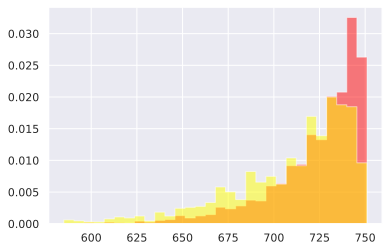

In [58]:
default = train.loc[
        (train ['Credit Default'] == 1) & (train['Credit Score'] < 800), 'Credit Score'
]
not_default = train.loc[
        (train ['Credit Default'] == 0) & (train['Credit Score'] < 800), 'Credit Score'
]
plt.hist((default, not_default), 
         bins=30, 
         histtype='stepfilled', 
         alpha=0.5, 
         color=('yellow', 'red'),
         density=True, 
         label=('Credit Default 1', 'Credit Default 0')
);

Создадим новый признак 'Credit Score Cat'.

In [59]:
train['Credit Score Cat'] = 0
train.loc[(train['Credit Score'] > 800), 'Credit Score Cat'] = 1
train.loc[(train['Credit Score'] == 3000), 'Credit Score Cat'] = 2
train.loc[(train['Credit Score'] < 735), 'Credit Score Cat'] = 2
train['Credit Score Cat'].astype('str')

0       0
1       0
2       0
3       2
4       2
       ..
7495    2
7496    1
7497    0
7498    2
7499    2
Name: Credit Score Cat, Length: 7500, dtype: object

In [60]:
test['Credit Score Cat'] = 0
test.loc[(test['Credit Score'] > 800), 'Credit Score Cat'] = 1
test.loc[(test['Credit Score'] == 3000), 'Credit Score Cat'] = 2
test.loc[(test['Credit Score'] < 735), 'Credit Score Cat'] = 2
test['Credit Score Cat'].astype('str')

0       2
1       2
2       1
3       0
4       2
       ..
2495    0
2496    2
2497    2
2498    0
2499    1
Name: Credit Score Cat, Length: 2500, dtype: object

#### Обзор категориальных признаков

In [61]:
for cat_col in train.select_dtypes(include='object').columns:
    print(f"\033[1m{cat_col}\033[0m\n{train[cat_col].value_counts()}\n{'*'* 50}\n")

Home Ownership
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
**************************************************

Years in current job
10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
**************************************************

Purpose
debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
***************************

In [62]:
# countplot по отношению к целевому признаку
def countplot(df, feature, targ, rotation=0):
    plt.figure(figsize=(10, 4))
    chart = sns.countplot(data=df, x=feature, hue=targ)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=rotation)
    plt.legend(title=targ, loc='upper right')

#### Признак 'Home Ownership'

In [63]:
# countplot(train, "Home Ownership", target)

Объединим категории Have Mortgage &#8594; Home Mortgage

In [64]:
train.loc[train["Home Ownership"] == 'Have Mortgage', "Home Ownership"] = 'Home Mortgage'
test.loc[test["Home Ownership"] == 'Have Mortgage', "Home Ownership"] = 'Home Mortgage'

#### Признак 'Years in current job'

In [65]:
# countplot(train, "Years in current job", target)

Признак "Years in current job" обладает числовыми значениями, но в каждом значении присутствует слово "year(s)". Предлагается оставить только числовые значения. Строки со значениями "10+ years" и  "< 1 year" преобразовать в 10 и 0

In [66]:
train["Years in current job"].value_counts()

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [67]:
replace_dict = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

train['Years in current job'].replace(replace_dict, inplace=True)
test['Years in current job'].replace(replace_dict, inplace=True)

#### Признак 'Purpose'

In [68]:
# countplot(train, "Purpose", target, rotation=45)

Предлагается уменьшить количество категорий.
Заменим отдельные категории покупок, требующие большого количества средств (раз на них всяли кредит), на 'major purchase'. А также заменим категорию 'small business' на 'business loan'

In [69]:
train.loc[train['Purpose'] == 'small business', 'Purpose'] = 'business loan'
train.loc[train['Purpose'] == 'buy a car', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'medical bills', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'take a trip', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'buy house', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'wedding', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'moving', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'educational expenses', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'vacation', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'renewable energy', 'Purpose'] = 'major purchase'

In [70]:
train['Purpose'].value_counts()

debt consolidation    5944
other                  665
home improvements      412
major purchase         324
business loan          155
Name: Purpose, dtype: int64

In [71]:
test.loc[test['Purpose'] == 'small business', 'Purpose'] = 'business loan'
test.loc[test['Purpose'] == 'buy a car', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'medical bills', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'take a trip', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'buy house', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'wedding', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'moving', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'educational expenses', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'vacation', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'renewable energy', 'Purpose'] = 'major purchase'

#### Признак 'Term'

In [72]:
# countplot(train, "Term", target)

Преобразуем значения признака Term в 0 и 1: Long Term - 1, Short Term - 0

In [73]:
train.loc[train['Term'] == 'Long Term', 'Term'] = 1
train.loc[train['Term'] == 'Short Term', 'Term'] = 0
test.loc[test['Term'] == 'Long Term', 'Term'] = 1
test.loc[test['Term'] == 'Short Term', 'Term'] = 0
train['Term'] = train['Term'].astype('int')
test['Term'] = test['Term'].astype('int')

In [74]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Id                                  7500 non-null   int64  
 1   Home Ownership                      7500 non-null   object 
 2   Annual Income                       7500 non-null   float64
 3   Years in current job                7500 non-null   int64  
 4   Tax Liens                           7500 non-null   int64  
 5   Number of Open Accounts             7500 non-null   float64
 6   Years of Credit History             7500 non-null   float64
 7   Maximum Open Credit                 7500 non-null   float64
 8   Number of Credit Problems           7500 non-null   int64  
 9   Months since last delinquent        7500 non-null   int64  
 10  Bankruptcies                        7500 non-null   int64  
 11  Purpose                             7500 no

**Все пропуски заполнены**

### Отбор признаков

In [75]:
# basic_features = train.columns.drop(target).drop('Id').tolist()
basic_features = train.columns.drop(target).tolist()
basic_features

['Id',
 'Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Current Loan Amount_Credit Default',
 'Credit Score Cat']

In [76]:
numeric_features = train.select_dtypes(
                    include='float').columns.tolist()
numeric_features

['Annual Income',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [77]:
category_features = train.select_dtypes(
                    include=('object')).columns.tolist()
category_features

['Home Ownership', 'Purpose']

In [78]:
selected_features = basic_features
selected_features

['Id',
 'Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Current Loan Amount_Credit Default',
 'Credit Score Cat']

При работе с CatBoost не требуется преобразование в dummies.

In [79]:
# CAT_DATASET_PATH = 'for_cat.csv'
# train.to_csv(CAT_DATASET_PATH, index=False, encoding='utf-8')

# CAT_TEST_DATASET_PATH = 'for_cat_test.csv'
# test.to_csv(CAT_TEST_DATASET_PATH, index=False, encoding='utf-8')

**Dummies**

In [80]:
# train = pd.get_dummies(train)
# test = pd.get_dummies(test)

#### Список новых признаков

In [81]:
# basic_feats = train.columns.drop(target).drop('Id').tolist()
basic_feats = train.columns.drop(target).tolist()

In [82]:
numeric_feats = train.select_dtypes(include='float').columns.tolist()

In [83]:
category_feats = train.select_dtypes(include=('uint8')).columns.tolist()

In [84]:
selected_feats = basic_feats

#### Проверка корреляции с целевым признаком

In [85]:
# corr_with_target = train[selected_feats + 
#                          [target]].corr().loc[target].sort_values(ascending=False)
# plt.figure(figsize=(8, 8))
# sns.barplot(x=corr_with_target.values, 
#             y=corr_with_target.index)
# plt.title('Корреляция с целевым признаком');

### Нормализация данных, разделенеи на тренеровачный и тестовые датасеты, балансироква целевого признака

In [86]:
def norm_data(train, test, features, scaler):
    '''Нормализация'''
    train_norm = train.copy()
    train_norm[features] = scaler.fit_transform(train_norm[features])
    test_norm = test.copy()
    test_norm[features] = scaler.transform(test_norm[features])
    return train_norm, test_norm

In [113]:
# MinMaxScaler
train_norm_mm, test_norm_mm = norm_data(
    train, test, 
    numeric_feats, 
    MinMaxScaler()
)

In [88]:
# StandardScaler
train_standard, test_standard = norm_data(
    train, test, 
    numeric_feats, 
    StandardScaler()
)

In [89]:
def balance_df_by_target(df, target_name):
    '''Балансировка целевого признака'''
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / 
                           target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(
                                target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [108]:
def split_and_balance_df(train_norm, selected_feats, test_size):
    '''Разаделение на X_train, y_train и сбалансированный X_train'''
    X = train_norm[selected_feats]
    y = train_norm[target]
#     X_train, X_test, y_train, y_test = train_test_split(
#                 X, y, shuffle=True, test_size=test_size, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(
                X, y, shuffle=True, test_size=test_size
    )
#     print('----------')
#     print(X_train.info())
#     print(X_test.info())
#     print('----------')
    df_for_balancing = pd.concat([X_train, y_train], axis=1)
    df_balanced = balance_df_by_target(df_for_balancing, target)
    X_train = df_balanced.drop(columns=target)
    y_train = df_balanced[target]
    return X_train, X_test, y_train, y_test

### Работа с моделью

In [93]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    '''Print the report'''
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [94]:
def model(model, X_train, y_train, X_test, y_test, features):
    '''Return model'''
    model.fit(X_train[features], y_train) 
    y_train_pred = model.predict(X_train[features])
    y_test_pred = model.predict(X_test[features])
    print(get_classification_report(y_train, y_train_pred, y_test, y_test_pred))
    return model

## CatBoost

In [127]:
selected_features.remove('Id')

ValueError: list.remove(x): x not in list

In [97]:
# train_norm_cat, test_norm_cat = norm_data(
#     train, test, numeric_features, MinMaxScaler())

In [98]:
# train_norm_cat_s, test_norm_cat_s = norm_data(
#     train, test, numeric_features, StandardScaler())

In [129]:
X_train_mms, X_test_mms, y_train_mms, y_test_mms = split_and_balance_df(
        train_norm_mm, selected_features, test_size=0.5
)

In [92]:
# X_train_s, X_test_s, y_train_s, y_test_s = split_and_balance_df(
#         train_standard, selected_feats, test_size=0.25
# )

In [92]:
# X_train_s, X_test_s, y_train_s, y_test_s = split_and_balance_df(
#         train_standard, selected_feats, test_size=0.25
# )

In [111]:
# X_cat_train_without_norm, X_cat_test_without_norm, y_cat_train_without_norm, y_cat_test_without_norm = split_and_balance_df(
#     train, selected_features, test_size=0.5)

In [110]:
# X_cat_train_without_norm.info()

In [ ]:
# X_cat_train, X_cat_test, y_cat_train, y_cat_test = split_and_balance_df(
#     train_norm_cat, selected_features, test_size=0.25)

In [ ]:
# X_cat_train_s, X_cat_test_s, y_cat_train_s, y_cat_test_s = split_and_balance_df(
#     train_norm_cat_s, selected_features, test_size=0.25)

In [130]:
# CatBoost
# model_catb_without_norm = model(catb.CatBoostClassifier
#                    (cat_features=category_features, 
#                      l2_leaf_reg=300, 
#                      random_state=42, 
#                      silent=True), 
#                    X_cat_train_without_norm, y_cat_train_without_norm, 
#                    X_cat_test_without_norm, y_cat_test_without_norm, 
#                    features=selected_features)

In [131]:
# CatBoost & MinMaxScaler
model_catb_mms = model(catb.CatBoostClassifier
                   (cat_features=category_features,
                    l2_leaf_reg=300,
                     random_state=42, 
                     silent=True), 
                   X_train_mms, y_train_mms, 
                   X_test_mms, y_test_mms, 
                   features=selected_features)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.90      0.83      2690
           1       0.84      0.67      0.74      2120

    accuracy                           0.80      4810
   macro avg       0.81      0.78      0.79      4810
weighted avg       0.80      0.80      0.79      4810

TEST

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      2697
           1       0.55      0.49      0.52      1053

    accuracy                           0.75      3750
   macro avg       0.68      0.67      0.67      3750
weighted avg       0.74      0.75      0.74      3750

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               2282  415
1                540  513
None


In [ ]:
# CatBoost & StandardScaler
# model_catb_s = model(catb.CatBoostClassifier
#                      (cat_features=category_features, 
#                        l2_leaf_reg=300, 
#                        random_state=42, 
#                        silent=True), 
#                      X_cat_train_s, y_cat_train_s, 
#                      X_cat_test_s, y_cat_test_s, 
#                      features=selected_features)

#### Подбор гиперпараметров

In [120]:
params = {'n_estimators':[50, 75, 100, 150, 200, 300], 
          'max_depth':[5, 7, 10],
          'learning_rate':[0.001, 0.01, 0.05, 0.1]}

In [121]:
cv=KFold(n_splits=5, shuffle=True)

In [ ]:
rs = RandomizedSearchCV(model_catb_mms, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train_mms, y_train_mms)

In [ ]:
(rs.best_params_, rs.best_score_)

In [122]:
# model_catb_without_norm = model(
#     catb.CatBoostClassifier(
#         cat_features=category_features, 
#         l2_leaf_reg=300,
#         random_state=42,
#         n_estimators=300,
#         max_depth=5,
#         learning_rate=0.05,
#         silent=True
#     ), 
#     X_cat_train_without_norm,
#     y_cat_train_without_norm, 
#     X_cat_test_without_norm,
#     y_cat_test_without_norm,
#     features=selected_features)

In [132]:
model_catb_mms = model(
    catb.CatBoostClassifier(
        cat_features=category_features, 
        l2_leaf_reg=300,
        random_state=42,
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        silent=True
    ), 
    X_train_mms,
    y_train_mms,
    X_test_mms,
    y_test_mms, 
    features=selected_features)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.88      0.79      2690
           1       0.78      0.56      0.65      2120

    accuracy                           0.74      4810
   macro avg       0.75      0.72      0.72      4810
weighted avg       0.75      0.74      0.73      4810

TEST

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      2697
           1       0.56      0.48      0.51      1053

    accuracy                           0.75      3750
   macro avg       0.68      0.66      0.67      3750
weighted avg       0.74      0.75      0.74      3750

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               2301  396
1                551  502
None


In [ ]:
# model_catb = model(
#     catb.CatBoostClassifier(
#         cat_features=category_features,
#         l2_leaf_reg=300,
#         random_state=42,
#         n_estimators=300,
#         max_depth=5,
#         learning_rate=0.05,
#         silent=True
#     ), 
# X_cat_train, y_cat_train, 
# X_cat_test, y_cat_test, 
# features=selected_features
# )

### Выбор наиболее важных признаков

In [134]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (10, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

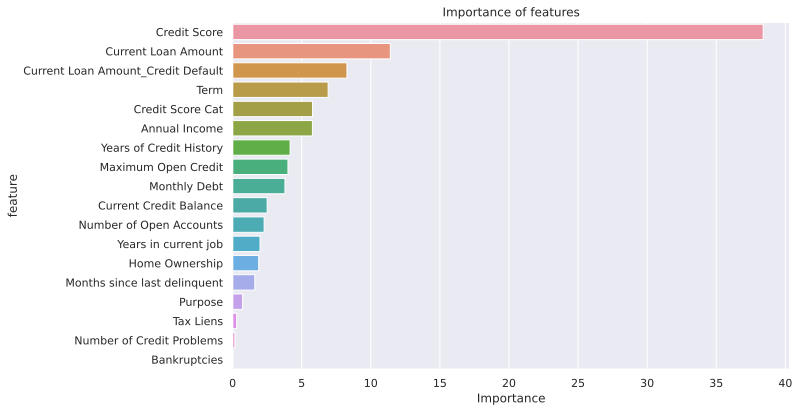

In [135]:
important_features_top = show_feature_importances(
                    X_train_mms.columns, 
                    model_catb_mms.feature_importances_, 
                    get_top=15
)

In [136]:
model_catb_mms = model(
    catb.CatBoostClassifier(
        cat_features=category_features, 
        l2_leaf_reg=300,
        random_state=42,
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        silent=True
    ), 
    X_train_mms,
    y_train_mms,
    X_test_mms,
    y_test_mms, 
    features=important_features_top
)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.88      0.79      2690
           1       0.79      0.58      0.67      2120

    accuracy                           0.75      4810
   macro avg       0.76      0.73      0.73      4810
weighted avg       0.75      0.75      0.74      4810

TEST

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      2697
           1       0.56      0.48      0.52      1053

    accuracy                           0.75      3750
   macro avg       0.68      0.67      0.67      3750
weighted avg       0.74      0.75      0.74      3750

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               2299  398
1                545  508
None


In [ ]:
# X_test.info()

In [137]:
# model_catb_without_norm = model(
#     catb.CatBoostClassifier(
#         cat_features=category_features, 
#         l2_leaf_reg=300,
#         random_state=42,
#         n_estimators=300,
#         max_depth=5,
#         learning_rate=0.05,
#         silent=True
#     ), 
#     X_cat_train_without_norm,
#     y_cat_train_without_norm, 
#     X_cat_test_without_norm,
#     y_cat_test_without_norm,
#     features=important_features_top
# )

## Предсказания тестовых данных¶

In [138]:
test['Credit Default'] = model_catb_mms.predict(test[important_features_top])
test['Credit Default'] = test['Credit Default'].astype('int')
PRED_PATH = './kaggle/damkkh_predictions_20201031_0648.csv'
test.loc[:, ['Id', 'Credit Default']].to_csv(
    PRED_PATH, index=False, encoding='utf-8')

In [ ]:
# pred_test = model_catb.predict(test)